In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.utils.data as data_utils
from torch.autograd import Variable
import math
import torchvision.models as models
from PIL import Image
import tensorflow as tf
import os
import copy
import sklearn.datasets
import sklearn.model_selection
import sklearn.preprocessing

In [3]:
from time import time

import torch
import sklearn.datasets
import sklearn.preprocessing
import sklearn.model_selection
import numpy as np
import math
import matplotlib.pyplot as plt

from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST as FMNIST
from torchvision.datasets import EMNIST
import torchvision.transforms as transforms

import Onlinehd

SEED = 1234
device = 'cuda' if torch.cuda.is_available() else 'cpu'
np.random.seed(SEED)
torch.manual_seed(SEED)

### Load Function MNIST(Digits), FMNIST, EMNIST(Letters)

In [4]:
def load():
    download_root = 'data/emnist_dataset'
    
    temp = EMNIST(download_root, split = 'letters', train=True, download=True)
    x = temp.data.unsqueeze(3).numpy().transpose((0,2,1,3))
    y = temp.targets.numpy() - 1
    temp = EMNIST(download_root, split='letters', train=False, download=True)
    x_test = temp.data.unsqueeze(3).numpy().transpose((0,2,1,3))
    y_test = temp.targets.numpy() - 1
    
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).long()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long()
    
    x_test = x_test.float()
    y_test = y_test.long().squeeze()

    if len(x.shape) != 3:
        x = x.squeeze(3)
        x_test = x_test.squeeze(3)
    
    return x, x_test, y, y_test

In [5]:
e_x, e_x_test, e_y, e_y_test = load()

/Users/jeongseongheon/opt/anaconda3/envs/UCI/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
e_x = e_x.reshape(-1, 784)
e_x_test = e_x_test.reshape(-1, 784)

e_scaler = sklearn.preprocessing.Normalizer().fit(e_x.reshape(-1, 784))
e_x = torch.tensor(e_scaler.transform(e_x.reshape(-1, 784)))
e_x_test = torch.tensor(e_scaler.transform(e_x_test.reshape(-1, 784)))

In [8]:
from time import time

e_classes = e_y.unique().size(0)
e_features = e_x.size(1)
Emodel = Onlinehd.OnlineHD(e_classes, e_features, dim=10000)

if torch.cuda.is_available():
    e_x = e_x.cuda()
    e_y = e_y.cuda()
    e_x_test = e_x_test.cuda()
    e_y_test = e_y_test.cuda()
    Emodel = Emodel.to('cuda')
    print('Using GPU!')

print('Training...')
t = time()
Emodel = Emodel.fit(e_x, e_y, bootstrap=1.0, lr=0.035, epochs=20)
t = time() - t

Training...
0
10


In [9]:
print('Validating...')
e_yhat = Emodel(e_x)
e_yhat_test = Emodel(e_x_test)

e_acc = (e_y == e_yhat).float().mean()
e_acc_test = (e_y_test == e_yhat_test).float().mean()

print(f'{e_acc = :6f}')
print(f'{e_acc_test = :6f}')
print(f'{t = :6f}')

Validating...
e_acc = 0.860625
e_acc_test = 0.832452
t = 82.351408


# Generate DeepFool

In [10]:
import numpy as np
from torch.autograd import Variable
import torch as torch
import copy
#from torch.autograd.gradcheck import zero_gradients

def zero_gradients(x):
    if isinstance(x, torch.Tensor):
        if x.grad is not None:
            x.grad.detach_()
            x.grad.zero_()
    elif isinstance(x, collections.abc.Iterable):
        for elem in x:
            zero_gradients(elem)

is_cuda = torch.cuda.is_available()

def deepfool(image, net, num_classes=26, overshoot=0.02, max_iter=10):  #num_classes; mnist:10/ fmnist:10 / emnist:26

    """
       :param image: Image of size HxWx3
       :param net: network (input: images, output: values of activation **BEFORE** softmax).
       :param num_classes: num_classes (limits the number of classes to test against, by default = 10)
       :param overshoot: used as a termination criterion to prevent vanishing updates (default = 0.02).
       :param max_iter: maximum number of iterations for deepfool (default = 50)
       :return: minimal perturbation that fools the classifier, number of iterations that it required, new estimated_label and perturbed image
    """
   
    image = image
    model = net

    I = torch.argsort(-model.scores(image)).tolist()[0]  # sort image score (descending)
    label = I[0]  #label

    input_shape = image.cpu().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    x = Variable(pert_image[None, :], requires_grad=True)
    fs = model.scores(x)
    fs_list = [fs[0,I[k]] for k in range(num_classes)]
    k_i = label

    while k_i == label and loop_i < max_iter:

#         pert = image.max().item()
        pert = image.max().item()
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.cpu().numpy().copy()

        for k in range(1, num_classes):
            zero_gradients(x)

            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.cpu().numpy().copy()

            # set new w_k and new f_k

            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())
            
            # determine which w_k to use
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # compute r_i and r_tot
        # Added 1e-4 for numerical stability
        r_i =  (pert+1e-4) * w / (np.linalg.norm(w) + 0.001)
        r_tot = np.float32(r_tot + r_i)*3

        pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)
        
        x = Variable(pert_image, requires_grad=True)
        fs = model.scores(x)
        k_i = torch.argsort(-fs).tolist()[0][0]  # labels for x

        loop_i += 1

    #r_tot = (1+overshoot)*r_tot

    return pert_image, torch.from_numpy(r_tot.reshape(28, 28)) #loop_i, label, k_i,

In [11]:
e_X_te_cln = e_x_test.reshape(-1,1,784)  # x_test
e_Y_te_cln = e_y_test #y_test
e_X_te_cln.shape, e_Y_te_cln.shape

(torch.Size([20800, 1, 784]), torch.Size([20800]))

In [18]:
from tqdm import tqdm

x_train_adv = torch.zeros(e_X_te_cln.shape)
x_test_pert = torch.zeros(20800, 28, 28)

In [19]:
for i in tqdm(range(20800)):
    x_train_adv[i], x_test_pert[i] = deepfool(e_X_te_cln[i], Emodel)

100%|███████████████████████████████████| 20800/20800 [6:37:09<00:00,  1.15s/it]


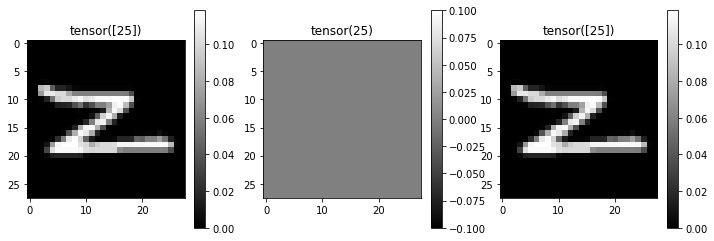

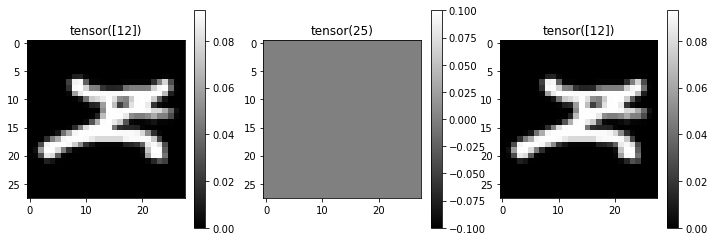

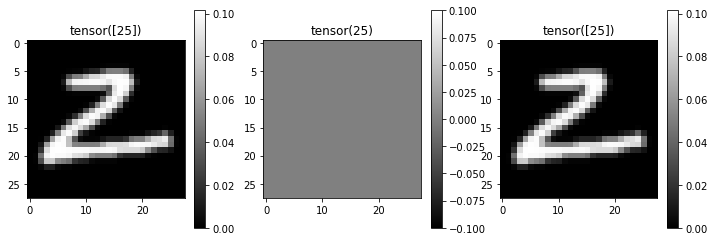

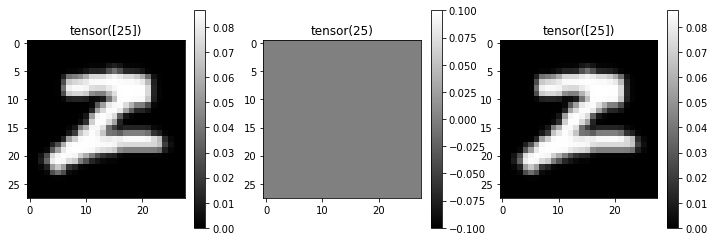

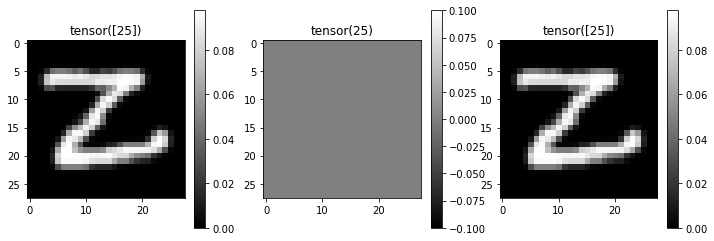

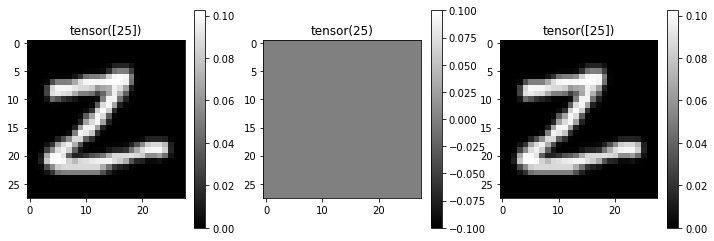

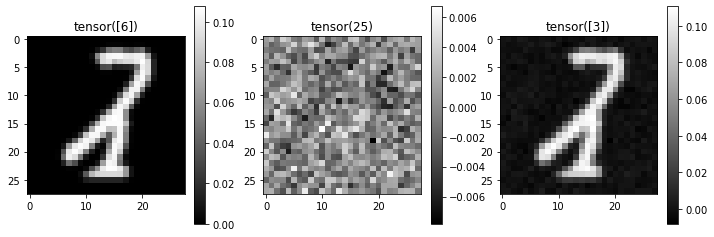

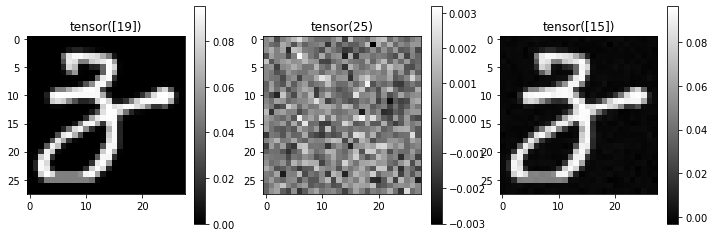

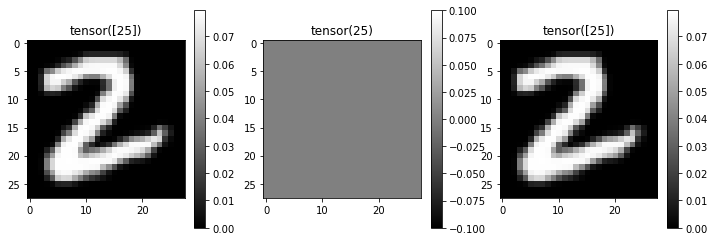

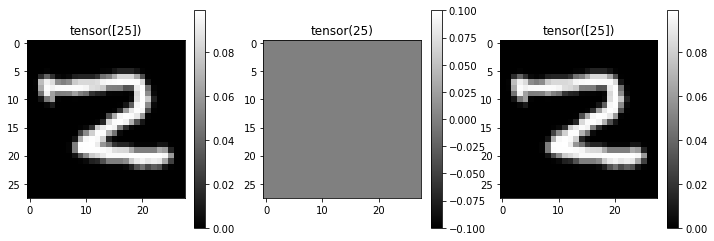

In [20]:
for i in range(10):
    i = i + 20700
    plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(e_x_test[i].reshape(28, 28), cmap='gray')
    plt.title(str(Emodel(e_x_test[i].reshape(1, 784))))
    plt.colorbar()
    
    plt.subplot(132)
    plt.imshow(x_test_pert[i].reshape(28, 28), cmap='gray')
    plt.title(str(e_y_test[i]))
    plt.colorbar()
    
    plt.subplot(133)
    plt.imshow(x_train_adv[i].reshape(28, 28), cmap='gray')
    plt.title(str(Emodel(torch.from_numpy(e_scaler.transform(x_train_adv[i].reshape(1, 784))).float())))
    plt.colorbar()
    
    plt.show()

In [21]:
x_train_adv = x_train_adv.squeeze()

In [22]:
print('Validating...')
e_yhat = Emodel(e_x)
e_yhat_test = Emodel(e_x_test)
e_yhat_attack = Emodel(torch.tensor(e_scaler.transform(x_train_adv)).float())

e_acc = (e_y == e_yhat).float().mean()
e_acc_test = (e_y_test == e_yhat_test).float().mean()
e_acc_attack = (e_y_test == e_yhat_attack).float().mean()

print(f'{e_acc = :6f}')
print(f'{e_acc_test = :6f}')
print(f'{e_acc_attack = :6f}')
print(f'{t = :6f}')

Validating...
e_acc = 0.860625
e_acc_test = 0.832452
e_acc_attack = 0.576635
t = 82.351408


In [24]:
import pickle 

data = {'data':x_train_adv,
       'label':e_y_test}

with open('EMNIST_DF_HD.pickle', 'wb') as f:
    pickle.dump(data, f)